In [ ]:
!pip install tensorflow

In [2]:
from typing import NamedTuple, Optional, Tuple, Generator

import numpy as np
from matplotlib import pyplot as plt
from skimage.draw import circle_perimeter_aa


class CircleParams(NamedTuple):
    row: int
    col: int
    radius: int


def draw_circle(img: np.ndarray, row: int, col: int, radius: int) -> np.ndarray:
    """
    Draw a circle in a numpy array, inplace.
    The center of the circle is at (row, col) and the radius is given by radius.
    The array is assumed to be square.
    Any pixels outside the array are ignored.
    Circle is white (1) on black (0) background, and is anti-aliased.
    """
    rr, cc, val = circle_perimeter_aa(row, col, radius)
    valid = (rr >= 0) & (rr < img.shape[0]) & (cc >= 0) & (cc < img.shape[1])
    img[rr[valid], cc[valid]] = val[valid]
    return img


def noisy_circle(
        img_size: int, min_radius: float, max_radius: float, noise_level: float
) -> Tuple[np.ndarray, CircleParams]:
    """
    Draw a circle in a numpy array, with normal noise.
    """

    # Create an empty image
    img = np.zeros((img_size, img_size))

    radius = np.random.randint(min_radius, max_radius)

    # x,y coordinates of the center of the circle
    row, col = np.random.randint(img_size, size=2)

    # Draw the circle inplace
    draw_circle(img, row, col, radius)

    added_noise = np.random.normal(0.5, noise_level, img.shape)
    img += added_noise

    return img, CircleParams(row, col, radius)


def show_circle(img: np.ndarray):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    ax.set_title('Circle')
    plt.show()


def generate_examples(
        noise_level: float = 0.5,
        img_size: int = 100,
        min_radius: Optional[int] = None,
        max_radius: Optional[int] = None,
        dataset_path: str = 'ds',
) -> Generator[Tuple[np.ndarray, CircleParams], None, None]:
    if not min_radius:
        min_radius = img_size // 10
    if not max_radius:
        max_radius = img_size // 2
    assert max_radius > min_radius, "max_radius must be greater than min_radius"
    assert img_size > max_radius, "size should be greater than max_radius"
    assert noise_level >= 0, "noise should be non-negative"

    params = f"{noise_level=}, {img_size=}, {min_radius=}, {max_radius=}, {dataset_path=}"
    print(f"Using parameters: {params}")
    while True:
        img, params = noisy_circle(
            img_size=img_size, min_radius=min_radius, max_radius=max_radius, noise_level=noise_level
        )
        yield img, params


def iou(a: CircleParams, b: CircleParams) -> float:
    """Calculate the intersection over union of two circles"""
    r1, r2 = a.radius, b.radius
    d = np.linalg.norm(np.array([a.row, a.col]) - np.array([b.row, b.col]))
    if d > r1 + r2:
        # If the distance between the centers is greater than the sum of the radii, then the circles don't intersect
        return 0.0
    if d <= abs(r1 - r2):
        # If the distance between the centers is less than the absolute difference of the radii, then one circle is
        # inside the other
        larger_r, smaller_r = max(r1, r2), min(r1, r2)
        return smaller_r ** 2 / larger_r ** 2
    r1_sq, r2_sq = r1**2, r2**2
    d1 = (r1_sq - r2_sq + d**2) / (2 * d)
    d2 = d - d1
    sector_area1 = r1_sq * np.arccos(d1 / r1)
    triangle_area1 = d1 * np.sqrt(r1_sq - d1**2)
    sector_area2 = r2_sq * np.arccos(d2 / r2)
    triangle_area2 = d2 * np.sqrt(r2_sq - d2**2)
    intersection = sector_area1 + sector_area2 - (triangle_area1 + triangle_area2)
    union = np.pi * (r1_sq + r2_sq) - intersection
    return intersection / union

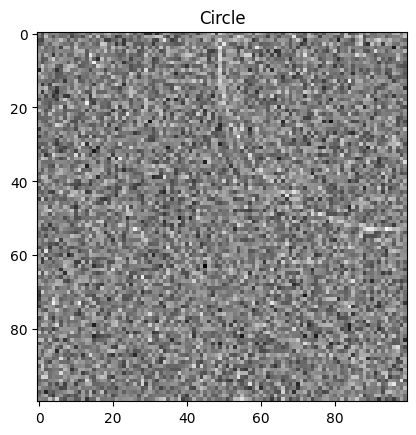

(100, 100)


In [3]:
# Generate one example image and circle parameters
example_img, circle_params = noisy_circle(img_size=100, min_radius=10, max_radius=50, noise_level=0.6)

# Display the generated image
show_circle(example_img)

print(example_img.shape)


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models


def create_circle_detector_model(input_shape=(100, 100, 1)):
    model = models.Sequential(
        [
            layers.Conv2D(128, (3, 3), activation="relu", input_shape=input_shape),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(256, (3, 3), activation="relu"),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(512, (3, 3), activation="relu"),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(512, (3, 3), activation="relu"),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(1024, activation="relu"),
            layers.Dense(512, activation="relu"),
            layers.Dense(3),  # Output layer for (x, y, radius)
        ]
    )
    return model


# Loss function


def custom_loss(y_true, y_pred):
    # Cast y_true to the same data type as y_pred

    y_true = tf.cast(y_true, y_pred.dtype)
    # Define loss function (e.g., mean squared error for (x, y) and radius)

    loss = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
    return loss


# Compile the model


model = create_circle_detector_model()
model.compile(optimizer="adam", loss=custom_loss)


def generate_train_data(
    batch_size: int = 32, noise_level: float = 0.5
) -> Tuple[np.ndarray, np.ndarray]:
    while True:
        images = []
        labels = []
        gen = generate_examples(noise_level=noise_level)
        for _ in range(batch_size):
            img, params = next(gen)
            images.append(np.expand_dims(img, axis=-1))
            labels.append(params)
        yield np.array(images), np.array(labels)


# Train the model


train_data = generate_train_data(noise_level=0.9)
model.fit(train_data, epochs=10, steps_per_epoch=200)

train_data = generate_train_data(noise_level=0.8)
model.fit(train_data, epochs=10, steps_per_epoch=200)

train_data = generate_train_data(noise_level=0.7)
model.fit(train_data, epochs=20, steps_per_epoch=200)

train_data = generate_train_data(noise_level=0.6)
model.fit(train_data, epochs=20, steps_per_epoch=200)

train_data = generate_train_data(noise_level=0.5)
model.fit(train_data, epochs=20, steps_per_epoch=200)

# Save the model


model.save("circle_detector_model.keras")


Utdata för streaming har trunkerats till de sista 5000 raderna.
 91/200 [============>.................] - ETA: 6s - loss: 36.0993Using parameters: noise_level=0.6, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'
Using parameters: noise_level=0.6, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'
 96/200 [=============>................] - ETA: 5s - loss: 35.2656Using parameters: noise_level=0.6, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'
Using parameters: noise_level=0.6, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'
105/200 [==============>...............] - ETA: 5s - loss: 34.4719Using parameters: noise_level=0.6, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'
Using parameters: noise_level=0.6, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'
113/200 [===============>..............] - ETA: 4s - loss: 34.3605Using parameters: noise_level=0.6, img_size=100, min_radius=10, max_radius=50, dataset_pat

In [5]:
# From StackOverflow-user Tommaso Di Noto https://stackoverflow.com/a/73414909


trainable_params = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
non_trainable_params = np.sum(
    [np.prod(v.get_shape()) for v in model.non_trainable_weights]
)
total_params = trainable_params + non_trainable_params

print("Trainable parameters:", trainable_params)
print("Non-trainable parameters:", non_trainable_params)
print("Total amount of parameters:", total_params)

Trainable parameters: 12752387
Non-trainable parameters: 0.0
Total amount of parameters: 12752387.0


In [4]:
print(model.input_shape)

(None, 100, 100, 1)


Utdata för streaming har trunkerats till de sista 5000 raderna.
1/1 [==============================] - 0s 29ms/step
Using parameters: noise_level=0.6, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'
1/1 [==============================] - 0s 31ms/step
Using parameters: noise_level=0.6, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'
1/1 [==============================] - 0s 25ms/step
Using parameters: noise_level=0.6, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'
1/1 [==============================] - 0s 25ms/step
Using parameters: noise_level=0.6, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'
1/1 [==============================] - 0s 27ms/step
Using parameters: noise_level=0.6, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'
1/1 [==============================] - 0s 24ms/step
Using parameters: noise_level=0.6, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'
1/1 [==============================] - 0s 

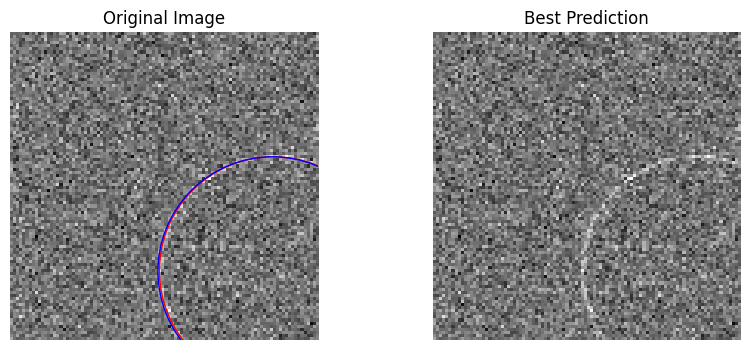

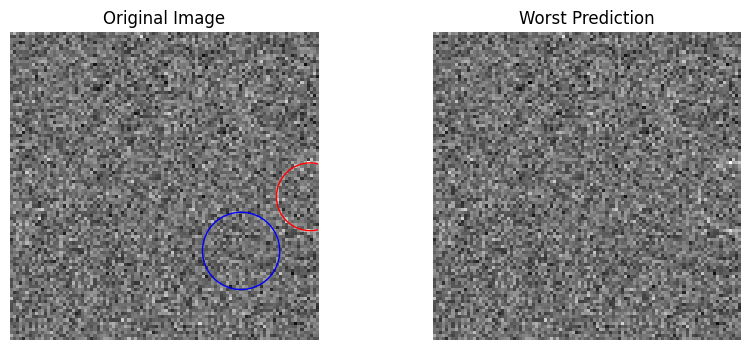



Measures for noise level: 0.5
Average IOU: 0.8428614379726439
Percentage of IoU over 0.5: 98.24%
Percentage of IoU over 0.75: 84.28%
Percentage of IoU over 0.9: 35.94%


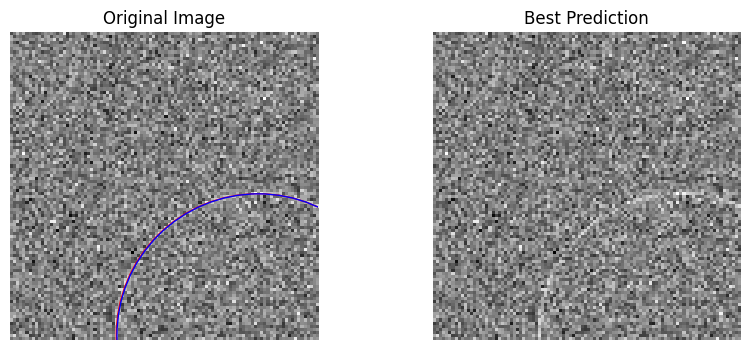

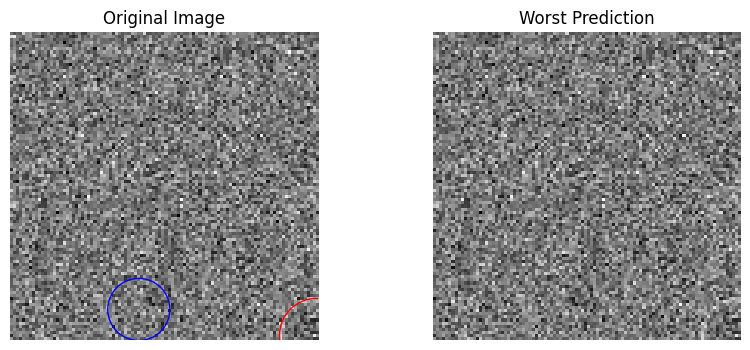



Measures for noise level: 0.6
Average IOU: 0.6500921158099726
Percentage of IoU over 0.5: 78.27%
Percentage of IoU over 0.75: 41.16%
Percentage of IoU over 0.9: 7.57%


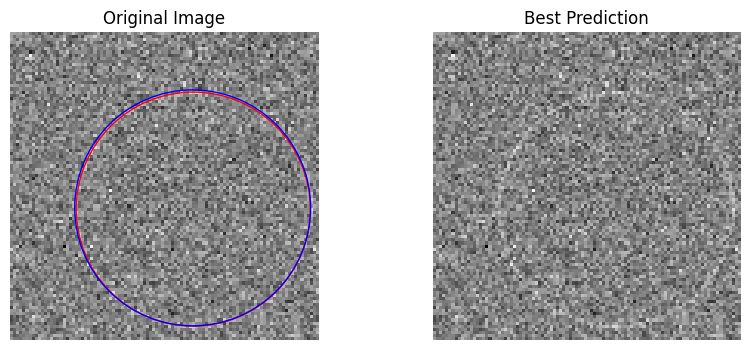

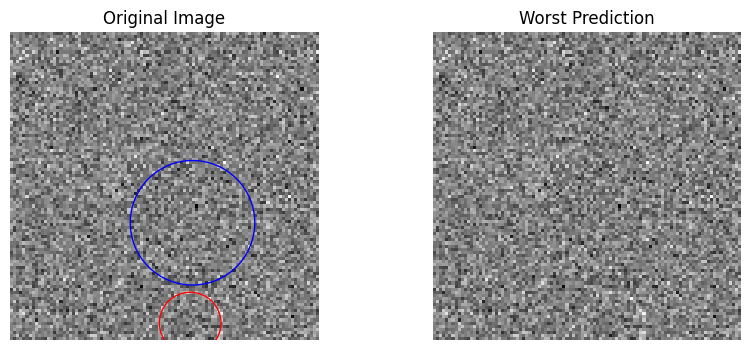



Measures for noise level: 0.7
Average IOU: 0.3600532404117393
Percentage of IoU over 0.5: 33.30%
Percentage of IoU over 0.75: 6.40%
Percentage of IoU over 0.9: 0.39%


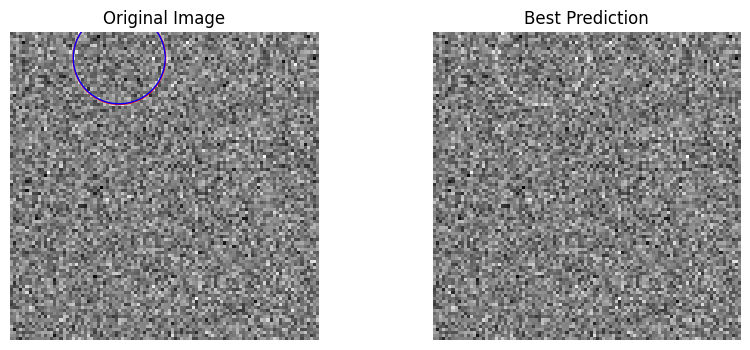

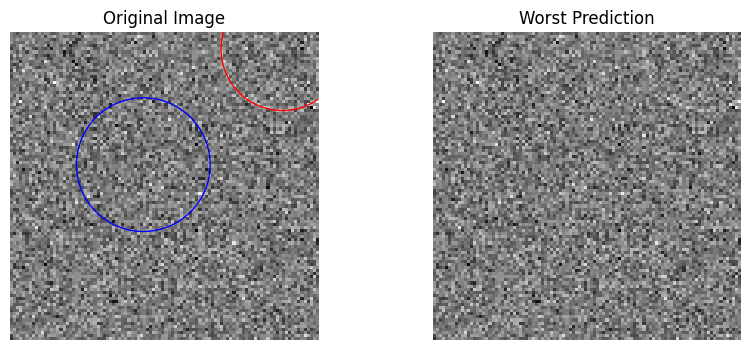

In [6]:
# Function to test the model on 2048 examples and compute average IoU


def test_model_with_best_worst_predictions(num_samples=2048, noise_level=0.5):
    best_iou = -1.0
    best_prediction = None
    worst_iou = 2.0
    worst_prediction = None
    total_iou = 0.0
    iou_over_05 = 0
    iou_over_075 = 0
    iou_over_09 = 0

    for _ in range(num_samples):
        # Generate a single example

        gen = generate_examples(noise_level=noise_level)
        img, true_params = next(gen)

        # Preprocess the image for prediction

        input_img = np.expand_dims(img, axis=0)
        input_img = np.expand_dims(input_img, axis=-1)

        # Predict using the model

        predicted_params = model.predict(input_img)[0]

        # Ensure true_params and predicted_params are of type CircleParams

        true_params = CircleParams(*true_params)
        predicted_params = CircleParams(*predicted_params)

        # Compute IoU between true and predicted circles

        pred_iou = iou(true_params, predicted_params)

        # Update best and worst predictions

        if pred_iou > best_iou:
            best_iou = pred_iou
            best_prediction = (img, true_params, predicted_params)
        if pred_iou < worst_iou:
            worst_iou = pred_iou
            worst_prediction = (img, true_params, predicted_params)
        # Accumulate IoU for average computation

        total_iou += pred_iou

        # Update counts for IoU thresholds

        if pred_iou > 0.5:
            iou_over_05 += 1
        if pred_iou > 0.75:
            iou_over_075 += 1
        if pred_iou > 0.9:
            iou_over_09 += 1
    # Compute average IoU

    average_iou = total_iou / num_samples
    print(f"Average IoU over {num_samples} samples: {average_iou:.4f}")

    # Compute percentages

    percent_over_05 = (iou_over_05 / num_samples) * 100
    percent_over_075 = (iou_over_075 / num_samples) * 100
    percent_over_09 = (iou_over_09 / num_samples) * 100

    return [
        percent_over_05,
        percent_over_075,
        percent_over_09,
        best_prediction,
        worst_prediction,
        average_iou,
        noise_level,
    ]


def plot_predictions(prediction, title):
    img, true_params, predicted_params = prediction

    # Display the image with the true and predicted circles

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    # Extract true circle parameters

    true_row, true_col, true_radius = true_params

    # Plot the true circle

    true_circle = plt.Circle((true_col, true_row), true_radius, color="r", fill=False)
    plt.gca().add_artist(true_circle)

    # Extract predicted circle parameters

    pred_row, pred_col, pred_radius = predicted_params

    # Plot the predicted circle

    pred_circle = plt.Circle((pred_col, pred_row), pred_radius, color="b", fill=False)
    plt.gca().add_artist(pred_circle)

    plt.subplot(1, 2, 2)
    plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()


# Test the model and plot best and worst predictions


noise_04 = test_model_with_best_worst_predictions(noise_level=0.4)
noise_05 = test_model_with_best_worst_predictions(noise_level=0.5)
noise_06 = test_model_with_best_worst_predictions(noise_level=0.6)
noise_07 = test_model_with_best_worst_predictions(noise_level=0.7)

noise_levels = [noise_04, noise_05, noise_06, noise_07]

for noise in noise_levels:
    print(f"Measures for noise_level = {noise[6]}")
    print(f"Average IOU: {noise[5]}")
    print(f"Percentage of IoU over 0.5: {noise[0]:.2f}%")
    print(f"Percentage of IoU over 0.75: {noise[1]:.2f}%")
    print(f"Percentage of IoU over 0.9: {noise[2]:.2f}%")

    # Plot best and worst predictions

    plot_predictions(noise[3], title="Best Prediction")
    plot_predictions(noise[4], title="Worst Prediction")
    print("\n")
